# Transfer Learning & Experiments

Experiment by creating a few models:
- `m0`: Use feature extraction transfer learning on `10%` of the training data 
- `m1`: Use feature extraction transfer learning on `1%` of the training data
  - **with data augmentation**
- `m2`: Use feature extraction transfer learning on `10%` of the training data
  - **with data augmentation**
  - save the results to a checkpoint
- `m3`: Fine-tune the m2 checkpoint on `10%` of the training data
  - **with data augmentation**
- `m4`: Fine-tune the m2 checkpoint on `100%` of the training data
  - **with data augmentation**

## Notebook Goals
- build at least 4 models, running at least 4 experiments on the data (see above)
- Compare the impact on model performance of 2 variables:
  - amount of training data
  - data augmentation
- Build a fn to augment-and-plot random images, comparing augmented-to-regular (_for visual review_)
- Use weight "checkpoints" to save model weights and build models from saved weights
- experiment with model variables:
  - amount of training data
  - number of trainable layers in a "base" model
  - number of epochs
 
## Imports

In [1]:
import tensorflow as tf
from keras.callbacks import CSVLogger
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
import numpy as np

In [2]:
## Download Helper Functions
# Download helper_functions.py script
# !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import helper functions we're going to use
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

## Get Data

In [3]:
# 
# 10% set of data based on the food101 dataset
# 

# !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
# unzip_data("10_food_classes_10_percent.zip")


# 
# 1%
# 
# !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
# unzip_data("10_food_classes_1_percent.zip")


# 
# ALL data
# 
# !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
# unzip_data("10_food_classes_all_data.zip")


### Preview the 1% data
- `7` images per class in training
- `250` images per class in testing

In [4]:
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/test'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/fried_rice'

## Data & Var Prep for multi-model experimentation

In [5]:
# 
# 10% of the data
# 
data_dir_path_10p = "10_food_classes_10_percent/"
train_dir_path_10p = data_dir_path_10p + "train/"
test_dir_path_10p = data_dir_path_10p + "test/"

# 
# 1% of the data
# 
data_dir_path_1p = "10_food_classes_1_percent/"
train_dir_path_1p = data_dir_path_1p + "train/"
test_dir_path_1p = data_dir_path_1p + "test/"


# 
# ALL of the data
# 
data_dir_path_100p = "10_food_classes_all_data/"
train_dir_path_100p = data_dir_path_100p + "train/"
test_dir_path_100p = data_dir_path_100p + "test/"

# data_dir_path_100p, train_dir_path_100p, test_dir_path_100p

IMG_OUTPUT_SIZE = (224, 224)
labelMode = "categorical"
# batchSize = 32
batchSize = 16

## Model I: train-on-10%
### Split Data: Test & Train

In [6]:
train_data_10p = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir_path_10p,
                                                                            image_size=IMG_OUTPUT_SIZE,
                                                                            label_mode=labelMode,
                                                                            batch_size=batchSize)
test_data_10p = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir_path_10p,
                                                                           image_size=IMG_OUTPUT_SIZE,
                                                                           label_mode=labelMode)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [7]:
# 
# inspect training data var
# 
train_data_10p

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [8]:
train_data_10p.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [9]:
# 
# see ALL methods available on the new vars
# 

# dir(train_data_10p)

In [10]:
# 
# preview some data using the "take" method
# 

# for images, labels in train_data_10p.take(1):
#   print(images,labels)

### Build, Compile & Fit

In [11]:
modelName = 'm0'
lessValidationDataCount = int(0.25 * len(test_data_10p))
csv_logger = CSVLogger(f'{modelName}-log.csv', append=True, separator=';')

# 
# pre-trained model
# 
# 1. Create base model with tf.keras.applications
# https://www.tensorflow.org/api_docs/python/tf/keras/applications/EfficientNetV2B0
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
# 2. Freeze the base model (so the pre-learned patterns remain)
base_model.trainable = False

# 
# custom layer(s)
# 
# 3. Create inputLayer into the base model
inputLayer = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")


# "4" If using ResNet50V2, add this to speed up convergence by rescaling inputs
# NOT for EfficientNetV2
# appliedModel = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputLayer)


# 5. Apply the inputLayer to the base_model (note: using tf.keras.applications, EfficientNetV2 inputLayer don't have to be normalized)
appliedModel = base_model(inputLayer)

# Check data shape after passing it to base_model
print(f"Shape after base_model: {appliedModel.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
appliedModel = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(appliedModel)
print(f"After GlobalAveragePooling2D(): {appliedModel.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(appliedModel)

# 8. Combine the inputLayer with the outputs into a model
m0 = tf.keras.Model(inputLayer, outputs)

# 9. Compile the model
m0.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# 10. Fit the model (we use less steps for validation so it's faster)
m0History = m0.fit(train_data_10p,
                                 epochs=5,
                                 steps_per_epoch=len(train_data_10p),
                                 validation_data=test_data_10p,
                                 # Go through LESS of the validation data so epochs are faster (we want faster experiments!)
                                 validation_steps=lessValidationDataCount,
                                 # Track our model's training logs for visualization later
                                 callbacks=[create_tensorboard_callback("transfer_learning", "10p_feature_extract"), csv_logger])

Shape after base_model: (None, 7, 7, 1280)
After GlobalAveragePooling2D(): (None, 1280)
Saving TensorBoard log files to: transfer_learning/10p_feature_extract/20240630-125727
Epoch 1/5
47/47 [==============================] - 62s 1s/step - loss: 1.7462 - accuracy: 0.4667 - val_loss: 1.1058 - val_accuracy: 0.7418
Epoch 2/5
47/47 [==============================] - 41s 878ms/step - loss: 0.9487 - accuracy: 0.7760 - val_loss: 0.7481 - val_accuracy: 0.8405
Epoch 3/5
47/47 [==============================] - 34s 728ms/step - loss: 0.6755 - accuracy: 0.8400 - val_loss: 0.6134 - val_accuracy: 0.8618
Epoch 4/5
47/47 [==============================] - 43s 926ms/step - loss: 0.5616 - accuracy: 0.8800 - val_loss: 0.5624 - val_accuracy: 0.8602
Epoch 5/5
47/47 [==============================] - 40s 854ms/step - loss: 0.4994 - accuracy: 0.8827 - val_loss: 0.5048 - val_accuracy: 0.8635


### Inspect Model
There is a `base_model` which is JUST the "starting place".  
There is also the `m0`, which is the transfer-learned model including our data.  


#### Summary

In [12]:
base_model.summary()

Model: "efficientnetv2-b0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, None, None, 3)        0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, None, None, 3)        0         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 stem_conv (Conv2D)          (None, None, None, 32)       864       ['normalizatio

In [13]:
m0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 5932122 (22.63 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 5919312 (22.58 MB)
__________________

### Visualize Loss & Accuracy Curves

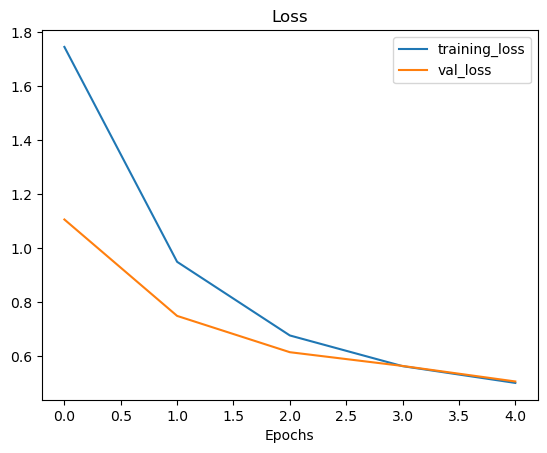

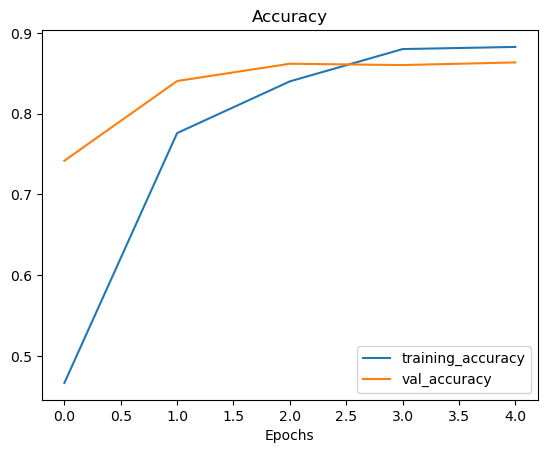

In [14]:
plot_loss_curves(m0History)

## Model II: train-on-1%-with-aug
### Split Data: Test & Train

In [15]:
train_data_1p = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir_path_1p,
                                                                            image_size=IMG_OUTPUT_SIZE,
                                                                            label_mode=labelMode,
                                                                            batch_size=batchSize)
test_data_1p = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir_path_1p,
                                                                           image_size=IMG_OUTPUT_SIZE,
                                                                           label_mode=labelMode)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


### Augment The Training Data
Using a `Sequential` keras model, a composed augmentation layer will be made. The augmentation layer will be made of several "inner" layers. The "inner" layers are the layers that will "augment" the data, as described by each layer:

In [16]:
augmentationLayer = keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomHeight(0.2),
  layers.RandomWidth(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetV2B0
], name ="data_augmentation")


# # NOTE: 
# Previous versions of TensorFlow (e.g. 2.4 and below) used 
# tensorflow.keras.layers.experimental.processing:

# augmentationLayer = keras.Sequential([
#   preprocessing.RandomFlip("horizontal"),
#   preprocessing.RandomRotation(0.2),
#   preprocessing.RandomZoom(0.2),
#   preprocessing.RandomHeight(0.2),
#   preprocessing.RandomWidth(0.2),
#   # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetV2B0
# ], name ="data_augmentation")

### Visualize Some Original & Augmented Images

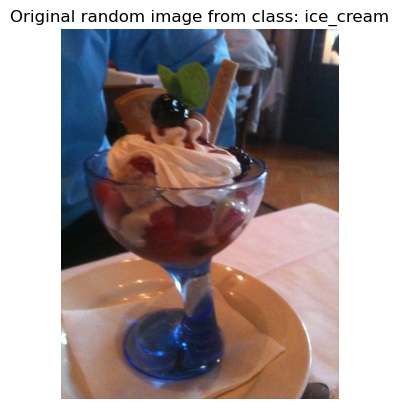

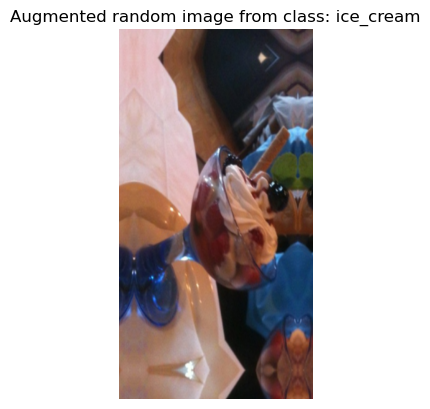

In [17]:
target_class = random.choice(train_data_1p.class_names) # choose a random class
target_dir = "10_food_classes_1_percent/train/" + target_class # create the target directory
random_image = random.choice(os.listdir(target_dir)) # choose a random image from target directory
random_image_path = target_dir + "/" + random_image # create the choosen random image path
img = mpimg.imread(random_image_path) # read in the chosen target image

plt.imshow(img) # plot the target image
plt.title(f"Original random image from class: {target_class}")
plt.axis(False); # turn off the axes

# Reshape, Augment, and ReNormalize
imgWithNewShape = tf.expand_dims(img, axis=0)
augmented_img = augmentationLayer(imgWithNewShape) # data augmentation model requires shape (None, height, width, 3)
normalizedAugmentedImg = tf.squeeze(augmented_img)/255. # requires normalization after augmentation

plt.figure()
plt.imshow(normalizedAugmentedImg)
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False);

### Build, Compile, Fit

In [18]:
# RE-Using inputLayer var from above

# Add in data augmentation Sequential model as a layer
applied1pAugModel = augmentationLayer(inputLayer)

# Give base_model inputLayer (after augmentation) and don't train it
applied1pAugModel = base_model(applied1pAugModel, training=False)

# Pool output features of base model
applied1pAugModel = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(applied1pAugModel)

# Put a dense layer on as the output
applied1pAugOutput = layers.Dense(10, activation="softmax", name="output_layer")(applied1pAugModel)

# Make a model with "inputs" and "outputs"
m1 = keras.Model(inputLayer, applied1pAugOutput)

# Compile the model
m1.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_1p = m1.fit(train_data_1p,
                    epochs=5,
                    steps_per_epoch=len(train_data_1p),
                    validation_data=test_data_1p,
                    validation_steps=int(0.25* len(test_data_1p)), # validate for less steps
                    # Track model training logs
                    callbacks=[create_tensorboard_callback("transfer_learning", "1p_data_aug")])

Saving TensorBoard log files to: transfer_learning/1p_data_aug/20240630-130113
Epoch 1/5
5/5 [==============================] - 27s 5s/step - loss: 2.3654 - accuracy: 0.0857 - val_loss: 2.1891 - val_accuracy: 0.2105
Epoch 2/5
5/5 [==============================] - 26s 6s/step - loss: 2.0906 - accuracy: 0.3000 - val_loss: 2.0225 - val_accuracy: 0.3240
Epoch 3/5
5/5 [==============================] - 33s 8s/step - loss: 1.8504 - accuracy: 0.5286 - val_loss: 1.9011 - val_accuracy: 0.3898
Epoch 4/5
5/5 [==============================] - 19s 5s/step - loss: 1.6234 - accuracy: 0.6857 - val_loss: 1.7648 - val_accuracy: 0.4918
Epoch 5/5
5/5 [==============================] - 17s 4s/step - loss: 1.4577 - accuracy: 0.7714 - val_loss: 1.6744 - val_accuracy: 0.5016


### Inspect Model
#### Summary

In [19]:
m1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                1281

In [20]:
m1.evaluate(test_data_1p)

79/79 [==============================] - 53s 668ms/step - loss: 1.6719 - accuracy: 0.5028


[1.6719319820404053, 0.5027999877929688]

### Visualize Loss & Accuracy Curves

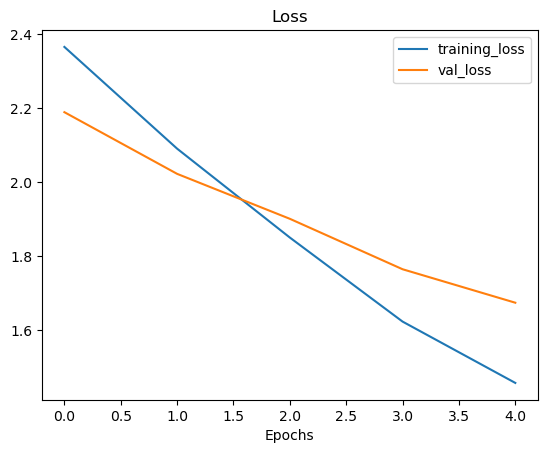

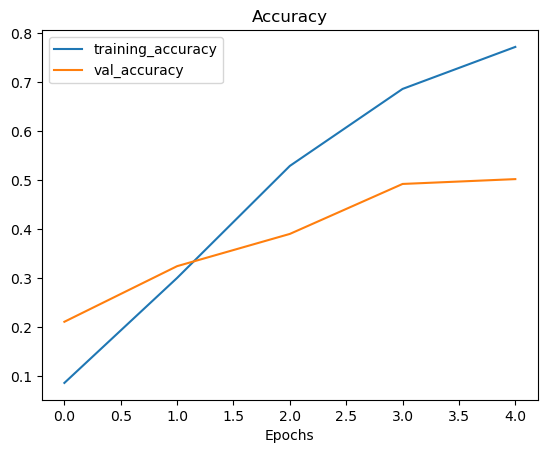

In [21]:
plot_loss_curves(history_1p)

## Model III: train-on-10%-with-aug
This uses a few of the same variables set above used in `m0`, as that model also used `10%` of the food101 dataset.  
This also uses data augmentation.  

### Build, Compile

In [22]:
appliedM210pAug = augmentationLayer(inputLayer) # augment our training images

# training=False: https://keras.io/guides/transfer_learning/#build-a-model
# pass augmented images to base model but keep it in inference mode, so batchnorm layers don't get updated

appliedM210pAug = base_model(appliedM210pAug, training=False)


appliedM210pAug = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(appliedM210pAug)
appliedM2Outputs = layers.Dense(10, activation="softmax", name="output_layer")(appliedM210pAug)
m2 = tf.keras.Model(inputLayer, appliedM2Outputs)

# Compile
m2.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), # use Adam optimizer with base learning rate
              metrics=["accuracy"])

### Create New Callback: ModelCheckpoint
[save the model OR model weights at a given frequency](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint)

In [23]:
savedCheckpointPath = "m3_10p_checkpoints_weights/checkpoint.ckpt"

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=savedCheckpointPath,
                                                         save_weights_only=True, # set to False to save the entire model
                                                         save_best_only=True, # save only the best model weights instead of a model every epoch
                                                         save_freq="epoch", # save every epoch
                                                         verbose=1)

### Fit

In [25]:
m2History = m2.fit(train_data_10p,
                                          epochs=5,
                                          validation_data=test_data_10p,
                                          validation_steps=int(0.25 * len(test_data_10p)), # do less steps per validation (quicker)
                                          callbacks=[create_tensorboard_callback("transfer_learning", "10p_data_aug"),
                                                     checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10p_data_aug/20240630-131025
Epoch 1/5
47/47 [==============================] - ETA: 0s - loss: 1.8759 - accuracy: 0.3813
Epoch 1: val_loss improved from inf to 1.22848, saving model to m3_10p_checkpoints_weights/checkpoint.ckpt
47/47 [==============================] - 47s 873ms/step - loss: 1.8759 - accuracy: 0.3813 - val_loss: 1.2285 - val_accuracy: 0.7204
Epoch 2/5
47/47 [==============================] - ETA: 0s - loss: 1.1850 - accuracy: 0.6907
Epoch 2: val_loss improved from 1.22848 to 0.84090, saving model to m3_10p_checkpoints_weights/checkpoint.ckpt
47/47 [==============================] - 32s 681ms/step - loss: 1.1850 - accuracy: 0.6907 - val_loss: 0.8409 - val_accuracy: 0.8059
Epoch 3/5
47/47 [==============================] - ETA: 0s - loss: 0.9438 - accuracy: 0.7387
Epoch 3: val_loss improved from 0.84090 to 0.70829, saving model to m3_10p_checkpoints_weights/checkpoint.ckpt
47/47 [==============================] - 31s 673

### Summarize, Visualize, Inspect

In [ ]:
m2_10p_aug_evaluated = m2.evaluate(test_data_10p)
m2_10p_aug_evaluated

In [ ]:
plot_loss_curves(m2History)

In [ ]:
m2.summary()

### Deep Inspection: Layers

In [ ]:
m2.layers

In [ ]:
for layer_number, layer in enumerate(m2.layers):
  print(f"Layer NUMBER: {layer_number} \t| NAME: {layer.name} \t| TYPE: {layer} \t| Trainable? {layer.trainable}")

## Load A Model From Checkpointed Weights
Model `m3` used the callback that saves weights to a checkpoint.  
The saved checkpoint can be used...
- reload the weights from the file
- evaluate the model
- compare SAVED weights to the NEW weights after using the model to evaluate on data

In [ ]:
# 
# load weights into a model
# 
m2.load_weights(savedCheckpointPath)

In [ ]:
# 
# evaluate the model against test data AFTER usings the checkpointd weights
# 
m2WithLoadedWeights = m2.evaluate(test_data_10p)

### Compare Model With And Without Checkpointed Weights

In [ ]:
# 
# COMPARE evaluate results:
# WITHOUT loaded weights
# WITH loaded weights
# 
m2WithLoadedWeights

In [ ]:
m2_10p_aug_evaluated

In [ ]:
# Check to see if loaded model results are very close to native model results (should output True)
np.isclose(np.array(m2WithLoadedWeights), np.array(m2_10p_aug_evaluated))

In [ ]:
# Check the difference between the two results (small values)
print(np.array(m2WithLoadedWeights) - np.array(m2_10p_aug_evaluated))

## Model IV: Fine-Tuning Model II
"UnFreezing" some layers in the pre-trained model.  
A workflow for fine-tuning:
- build a feature-extracted model
- train the weights in the output layer
- THEN un-freeze some layers and "work backwards" to unfreee more and more layers

### Inspecting Layers & Base Model

In [ ]:
m2.layers

In [ ]:
for layer_number, layer in enumerate(m2.layers):
  print(f"Layer #{layer_number}\n\tNAME: {layer.name}\n\t TYPE: {layer}\n\tTrainable? {layer.trainable}")

In [ ]:
m2BaseModel = m2.layers[2]
print(f'm3BaseModel: {m2BaseModel.name}')

In [ ]:
# to see ALL OF THE LAYERS IN THAT LAYER...

# for i, lyr in enumerate(m3.layers[2].layers):
#     print(i,lyr.name,lyr.trainable)


# how many TRAINABLE layers in that layer:
print(len(m2BaseModel.trainable_variables))

### UnFreeze Some (10) Base-Model Layers
This is the beginning of fine-tuning.  
Un-Freeze, Retrain, inspect, rinse & repeat.  

In [ ]:
# make trainable!
m2BaseModel.trainable = True

In [ ]:
# Re-Freeze all layers EXCEPT FOR the last 10
for layer in m2BaseModel.layers[:-10]:
  layer.trainable = False

In [ ]:
# Check which layers are tuneable (trainable)
for layer_number, layer in enumerate(m3BaseModel.layers):
    if(layer.trainable == True):
        print(f'layer #{layer_number}, {layer.name}, is trainable')

### Re-Compile The Model
After making a change to the model, the model needs re-compiling.  
**NOTE**: the learning-rate will be smaller/more fine-tined to leverage fine-tuning better. Seems like [10x smaller learning-rate](https://arxiv.org/pdf/1801.06146) is a generally accepted place to start.

In [ ]:
# Recompile the whole model (always recompile after any adjustments to a model)
m2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # lr is 10x lower than before for fine-tuning
                metrics=["accuracy"])

In [ ]:
print(f'm2 now has {len(m2.trainable_variables)} trainable vars')

### Fit The Model

In [ ]:
initialEpochCount = 5
fineTuneEpochCount = initialEpochCount + 5

# Refit the model (same as model_2 except with more trainable layers)
m2FineTuneHistory = m2.fit(train_data_10p,
                                               epochs=fineTuneEpochCount,
                                               validation_data=test_data_10p,
                                               initial_epoch=m3History.epoch[-1], # START from last epoch of previous "m3.fit"
                                               validation_steps=int(0.25 * len(test_data_10p)),
                                               callbacks=[create_tensorboard_callback("transfer_learning", "10p_data_aug_fine_tuned")]) # name experiment appropriately

### Evaluate
m3 model.  
fine-tuned for 5 more epochs.  
a bunch of "un-frozen" layers in the pre-trained model, re-trained on OUR data!  

In [ ]:
plot_loss_curves(m2FineTuneHistory)

#### Compare Fine-Tuned to Pre-Fine-Tuned Model

In [ ]:
def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two model history objects.
    """
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    print(len(acc))

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    print(len(total_acc))
    print(total_acc)

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

In [ ]:
compare_historys(original_history=m3History,
                 new_history=m2FineTuneHistory,
                 initial_epochs=5)

## Model V: Fine-Tuning with 100% data
Model 3 is training on 10% of the data.  
Model 4 (_really an edited model 3_) is fine-tuning a pre-trained model.  
This model will start with the same "base" model that was used in model III, _"train-on-10%-with-aug"_:
- use `load_weights` to get a model setup to be similar to model III
- "open up" the weights for trainability
- fine-tune the model _using 100% of the data_ (instead of 10% in the previous model, model IV)

In [ ]:
# data_dir_path_100p, train_dir_path_100p, test_dir_path_100p
walk_through_dir("10_food_classes_all_data")

### Split Data

In [ ]:
IMG_SIZE = (224, 224)
train_data_100p = tf.keras.preprocessing.image_dataset_from_directory(train_dir_path_100p,
                                                                                 label_mode="categorical",
                                                                                 image_size=IMG_SIZE)

# Note: this is the same test dataset we've been using for the previous modelling experiments
test_data_100p = tf.keras.preprocessing.image_dataset_from_directory(test_dir_path_100p,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

### Evaluate m2 with all the test data

In [ ]:
m2.evaluate(test_data_100p)

### Build & Compile Model
This is the _same exact model config as the previous model_.  
(_this could be converted to a function for further re-usability_)

In [ ]:
# # Create base model
# m = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
# m4.trainable = False

# # Setup model input and outputs with data augmentation
# m4InputLayer = layers.Input(shape=(224, 224, 3), name="input_layer")
# appliedM4 = augmentationLayer(m4InputLayer)
# appliedM4 = m4(appliedM4, training=False)  # pass augmented images to base model but keep it in inference mode
# appliedM4 = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(appliedM4)
# m4OutputLayer = layers.Dense(units=10, activation="softmax", name="output_layer")(appliedM4)
# m3 = tf.keras.Model(m4InputLayer, m4OutputLayer)

# # Compile
# m4.compile(loss="categorical_crossentropy",
#               optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
#               metrics=["accuracy"])

### Load Weights into model
This makes m4 identical to m3

In [ ]:
# m4.load_weights(savedCheckpointPath)

In [ ]:
# m4.summary()

In [ ]:
# print(len(m4.trainable_variables))